# LSTM: Many-to-many setup

In [246]:
import re
import numpy as np
import unidecode
from keras.preprocessing.sequence import pad_sequences
from IPython import get_ipython;   
#get_ipython().magic('reset -sf')
import pandas
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

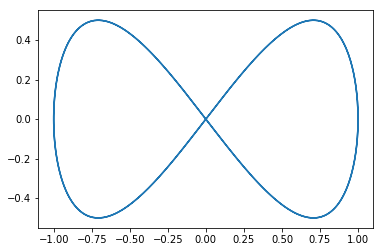

In [280]:
thetas = np.linspace(0,4*np.pi,1000)
dataset = np.array([np.sin(thetas),np.sin(thetas)*np.cos(thetas)]).T
dataset = dataset.astype('float32')
plt.plot(dataset[:,0],dataset[:,1])
plt.show()

In [282]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_back):
        print
        a = dataset[i:(i+look_back), :]
        b = dataset[(i+look_back):(i+look_back+look_back),:]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [283]:
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
trainX.shape,trainY.shape

((630, 20, 2), (630, 20, 2))

In [284]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def create_model(X_seq_len,X_seq_feat,Y_seq_len,Y_seq_feat, hidden_dim):
    # Set up input shape to encoder
    encoder_input_layer = Input(shape=(X_seq_len,X_seq_feat))
    
    # Define encoder
    encoder = LSTM(hidden_dim,return_state=True)
    # Encoder outputs - but only consider the memory and weights
    encoder_outputs, state_h, state_c = encoder(encoder_input_layer)
    encoder_states = [state_h,state_c]
    
    # We need to feed the decoder some zero inputs that is uncorrelated
    null_input = Input(shape=[Y_seq_feat])
    repeated_null = RepeatVector(Y_seq_len)(null_input)
    
    # Define decoder
    decoder = LSTM(hidden_dim,return_sequences=True, return_state=True)
    decoder_outputs,_,_ = decoder(repeated_null,initial_state=encoder_states)
    decoder_fully_connected = TimeDistributed(Dense(Y_seq_feat))(decoder_outputs)
    
    # Create final model
    model = Model([encoder_input_layer,null_input], decoder_fully_connected)
    
    # Compile model using loss
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model
    

In [285]:
input_len = 20
input_feat = 2
output_len = 20
output_feat = 2
hidden_dim = 20
model = create_model(input_len,input_feat,
                     output_len,output_feat,hidden_dim)
x = trainX[:,:,:]
y = trainY[:,:,:]
z = np.zeros((len(x),output_feat))
model.fit([x,z],y,epochs=100)

Epoch 1/100
630/630 [==============================] - 6s 10ms/step - loss: 0.3093
Epoch 2/100
630/630 [==============================] - 1s 798us/step - loss: 0.2269
Epoch 3/100
630/630 [==============================] - 1s 796us/step - loss: 0.1247
Epoch 4/100
630/630 [==============================] - 1s 803us/step - loss: 0.0707
Epoch 5/100
630/630 [==============================] - 1s 812us/step - loss: 0.0437
Epoch 6/100
630/630 [==============================] - 1s 804us/step - loss: 0.0253
Epoch 7/100
630/630 [==============================] - 1s 841us/step - loss: 0.0145
Epoch 8/100
630/630 [==============================] - 1s 803us/step - loss: 0.0084
Epoch 9/100
630/630 [==============================] - 0s 791us/step - loss: 0.0069
Epoch 10/100
630/630 [==============================] - 1s 798us/step - loss: 0.0061
Epoch 11/100
630/630 [==============================] - 1s 819us/step - loss: 0.0055
Epoch 12/100
630/630 [==============================] - 1s 802us/step - los

630/630 [==============================] - 1s 796us/step - loss: 2.2959e-05
Epoch 95/100
630/630 [==============================] - 0s 792us/step - loss: 2.0281e-05
Epoch 96/100
630/630 [==============================] - 0s 791us/step - loss: 1.9396e-05
Epoch 97/100
630/630 [==============================] - 0s 789us/step - loss: 1.7446e-05
Epoch 98/100
630/630 [==============================] - 0s 754us/step - loss: 2.1207e-05
Epoch 99/100
630/630 [==============================] - 0s 761us/step - loss: 2.9862e-05
Epoch 100/100
630/630 [==============================] - 0s 784us/step - loss: 2.6790e-05


In [286]:
xp = model.predict([x,z])

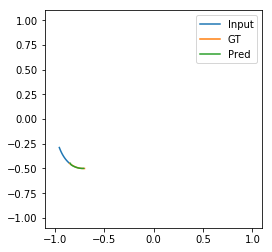

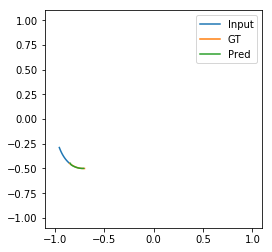

In [287]:
line, = plt.plot([],[],label='Input')
line1, = plt.plot([],[],label='GT')
line2, = plt.plot([],[],label='Pred')
plt.legend()
ax = plt.gca()
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')
for i in range(400):
    line.set_data(trainX[i,:,0],trainX[i,:,1])
    line1.set_data(trainY[i,:,0],trainY[i,:,1])
    line2.set_data(xp[i,:,0],xp[i,:,1])
    display.clear_output(wait=True)
    display.display(plt.gcf()) 